## Notebook to create figures with APGB meta data
Sources:
 - https://gis.stackexchange.com/questions/411376/wfs-layer-saved-as-a-shapefile
 - https://pcjericks.github.io/py-gdalogr-cookbook/vector_layers.html#get-wfs-layers-and-iterate-over-features
 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from osgeo import ogr, osr, gdal
import geopandas as gpd
import sys
from tqdm import tqdm 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
sys.path.append('../scripts/')
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
path_dict = loadpaths.loadpaths()

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


adding scrub
splitting up heath
adding wetland
adding transport


In [3]:
df_tile_outlines = lca.load_pols(path_dict['landscape_character_grid_path'])
df_pd_outline = lca.load_pols(path_dict['pd_outline'])
## only keep tiles that intersect with pd _outline 
df_tile_outlines = df_tile_outlines[df_tile_outlines.intersects(df_pd_outline.unary_union)]
df_tile_outlines = df_tile_outlines.reset_index(drop=True)
assert len(df_tile_outlines) == 1617
arr_tile_names = df_tile_outlines['PLAN_NO'].values


In [4]:
# 'SE0d503' in arr_tile_names

## Method 1: use WFS layer to get info of all tiles:

In [5]:
url = 'https://ogc.apps.midgard.airbusds-cint.com/apgb/wfs?service=WFS&guid=4cd2b5e0-41fd-41e1-90a8-09c2fb51cbf6&request=GetCapabilities'

In [6]:
# Set the driver (optional)
wfs_drv = ogr.GetDriverByName('WFS')

# Speeds up querying WFS capabilities for services with alot of layers
gdal.SetConfigOption('OGR_WFS_LOAD_MULTIPLE_LAYER_DEFN', 'NO')

# Set config for paging. Works on WFS 2.0 services and WFS 1.0 and 1.1 with some other services.
gdal.SetConfigOption('OGR_WFS_PAGING_ALLOWED', 'YES')
gdal.SetConfigOption('OGR_WFS_PAGE_SIZE', '10000')

# Open the webservice
# url = 'http://example-service.com/wfs'
wfs_ds = wfs_drv.Open('WFS:' + url)

In [ ]:
if False:
    ## Get info of all layers

    # iterate over available layers
    for i in range(wfs_ds.GetLayerCount()):
        layer = wfs_ds.GetLayerByIndex(i)
        srs = layer.GetSpatialRef()
        print('i: %s, Layer: %s, Features: %s, SR: %s...' % (i, layer.GetName(), layer.GetFeatureCount(), srs.ExportToWkt()[0:50]))


In [8]:
## Select layer:
layer = wfs_ds.GetLayerByIndex(3)
srs = layer.GetSpatialRef()
layer_name = layer.GetName()
n_features = layer.GetFeatureCount()
print('Layer: %s\nFeatures: %s\nSR: %s...' % (layer_name, n_features, srs.ExportToWkt()[0:50]))


Layer: apgb:AP-12CM5-GB-FOOTPRINTS-LATEST
Features: 157622
SR: PROJCS["OSGB 1936 / British National Grid",GEOGCS[...


In [9]:
## Iterate over features
refs_list, dates_list = [], []
count = 0
with tqdm(total=n_features) as pbar:
    feat = layer.GetNextFeature()
    while feat is not None:
        pbar.update(1)
        count += 1
        km_ref = feat.GetField('kmreference')
        if km_ref in arr_tile_names:
            date_flown = feat.GetField('dateflown')
            refs_list.append(km_ref)
            dates_list.append(date_flown)
            
        feat = layer.GetNextFeature()
        

100%|██████████| 157622/157622 [05:12<00:00, 504.70it/s] 


In [11]:
assert len(refs_list) == len(dates_list)
assert len(refs_list) == 1617
print('Found all %s tiles with date flown info' % len(refs_list))

Found 1617 tiles with date flown info


In [12]:
tile_list = []
for tn in refs_list:
    df_tmp = df_tile_outlines[df_tile_outlines['PLAN_NO'] == tn]
    assert len(df_tmp) == 1
    tile_list.append(df_tmp.iloc[0]['geometry'])

In [14]:
df_dateflown = gpd.GeoDataFrame({'tile_name': refs_list, 
                                 'dateflown': dates_list, 
                                 'geometry': tile_list})

In [18]:
df_dateflown['dateflown'].iloc[0]

'2019-04-22T00:00:00Z'

In [55]:
df_dateflown['year'] = df_dateflown['dateflown'].apply(lambda x: int(x.split('-')[0]))
df_dateflown['month'] = df_dateflown['dateflown'].apply(lambda x: int(x.split('-')[1]))
df_dateflown['day'] = df_dateflown['dateflown'].apply(lambda x: int(x.split('-')[2][:2]))
df_dateflown['date'] = df_dateflown['dateflown'].apply(lambda x: x.split('T')[0])

In [57]:
df_dateflown['date'].unique()

array(['2019-04-22', '2020-05-31', '2020-05-06', '2021-05-30',
       '2021-06-05', '2021-06-09', '2022-06-21'], dtype=object)

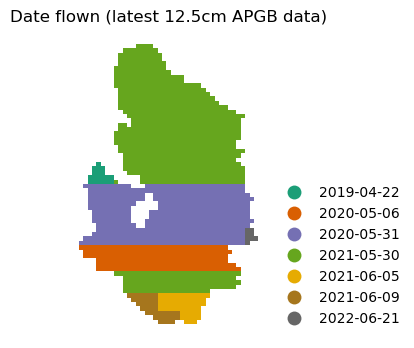

In [73]:
save_fig = True 

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
df_dateflown.plot(column='date', legend=True, ax=ax, 
                  legend_kwds={'loc': 'lower left', 'bbox_to_anchor': (1, 0), 'frameon': False},
                  cmap=plt.cm.get_cmap('Dark2', len(df_dateflown['date'].unique())))
ax.axis('off')
ax.set_title('Date flown (latest 12.5cm APGB data)')

if save_fig:
    plt.savefig('../figures/fig_dateflown_12cm5_APGB.pdf', bbox_inches='tight')

## Method 2; read from XML of saved files

In [62]:
import xml 
import os
from bs4 import BeautifulSoup as bs4
import pandas as pd 
import numpy as np

## List of folders of all data (in Thijs' case it's split up in two folders, not on Turing server)
dict_data_folders= {
    'RGB_2010': ['/home/tplas/data/gis/DSG/second_batch/second_batch_data/12.5cm Aerial Photo/2010-2017/',
                 '/home/tplas/data/gis/DSG/PDNPA_DSG_imagery_data/12.5cm Aerial Photo/2010-2017/'],
    'RGB_2020': ['/home/tplas/data/gis/DSG/second_batch/second_batch_data/12.5cm Aerial Photo/2020-2021/',
                 '/home/tplas/data/gis/DSG/PDNPA_DSG_imagery_data/12.5cm Aerial Photo/2020-2021/'],
    'CIR_2010': ['/home/tplas/data/gis/DSG/second_batch/second_batch_data/50cm Colour Infrared/2007-2017/',
                 '/home/tplas/data/gis/DSG/PDNPA_DSG_imagery_data/50cm Colour Infrared/2007-2017/'],
    'CIR_2020': ['/home/tplas/data/gis/DSG/second_batch/second_batch_data/50cm Colour Infrared/2020-2021/',
                 '/home/tplas/data/gis/DSG/PDNPA_DSG_imagery_data/50cm Colour Infrared/2020-2021/']
                    }

In [84]:
dict_dateflown = {}
list_dual = []

for key, folders in dict_data_folders.items():  # loop through all data folders
    dict_dateflown[key] = {}
    for fol in folders:
        print('Analysing', key, fol)
        list_tiles = os.listdir(fol)
        for tile in list_tiles:  # loop through all tile folders 
            files_tile = os.listdir(os.path.join(fol, tile))
            files_tile = [f for f in files_tile if f.endswith('.xml')]  # get xml 
            assert len(files_tile) == 1
            name_tile = files_tile[0].split('.')[0] # name of tile (eg SK0909)
            xml_file = os.path.join(fol, tile, files_tile[0])
            with open(xml_file, 'r') as f:
                xml_data = f.read()
            soup = bs4(xml_data, 'xml')
            soup_df = soup.find('dateFlown')  # for older dates, dateFlown is used
            if soup_df is not None:
                date_flown = soup_df.text
                soup_df_tmp = soup.find_all('dateFlown')
                if len(soup_df_tmp) > 1:
                    list_dual.append([name_tile, key, fol, files_tile[0]])
            else:
                soup_df = soup.find('DateTime')  # for newer dates, DateTime is used
                if soup_df is not None:
                    date_flown = soup_df.text[:10]  # go to yyyy-mm-dd format (ignore time)
                    soup_df_tmp = soup.find_all('DateTime')
                    if len(soup_df_tmp) > 1:
                        print('date captured')
                        list_dual.append([name_tile, key, fol, files_tile[0]])
                else:
                    assert False, soup 
            assert name_tile not in dict_dateflown[key]
            dict_dateflown[key][name_tile] = date_flown  # insert date flown into dict
            

Analysing RGB_2010 /home/tplas/data/gis/DSG/second_batch/second_batch_data/12.5cm Aerial Photo/2010-2017/
Analysing RGB_2010 /home/tplas/data/gis/DSG/PDNPA_DSG_imagery_data/12.5cm Aerial Photo/2010-2017/
Analysing RGB_2020 /home/tplas/data/gis/DSG/second_batch/second_batch_data/12.5cm Aerial Photo/2020-2021/
Analysing RGB_2020 /home/tplas/data/gis/DSG/PDNPA_DSG_imagery_data/12.5cm Aerial Photo/2020-2021/
Analysing CIR_2010 /home/tplas/data/gis/DSG/second_batch/second_batch_data/50cm Colour Infrared/2007-2017/
Analysing CIR_2010 /home/tplas/data/gis/DSG/PDNPA_DSG_imagery_data/50cm Colour Infrared/2007-2017/
Analysing CIR_2020 /home/tplas/data/gis/DSG/second_batch/second_batch_data/50cm Colour Infrared/2020-2021/
Analysing CIR_2020 /home/tplas/data/gis/DSG/PDNPA_DSG_imagery_data/50cm Colour Infrared/2020-2021/


In [85]:
list_dual

[['SK0698',
  'RGB_2010',
  '/home/tplas/data/gis/DSG/second_batch/second_batch_data/12.5cm Aerial Photo/2010-2017/',
  'SK0698.xml'],
 ['SK0598',
  'RGB_2010',
  '/home/tplas/data/gis/DSG/second_batch/second_batch_data/12.5cm Aerial Photo/2010-2017/',
  'SK0598.xml'],
 ['SK1862',
  'RGB_2010',
  '/home/tplas/data/gis/DSG/second_batch/second_batch_data/12.5cm Aerial Photo/2010-2017/',
  'SK1862.xml'],
 ['SK0498',
  'RGB_2010',
  '/home/tplas/data/gis/DSG/second_batch/second_batch_data/12.5cm Aerial Photo/2010-2017/',
  'SK0498.xml'],
 ['SK1196',
  'RGB_2010',
  '/home/tplas/data/gis/DSG/PDNPA_DSG_imagery_data/12.5cm Aerial Photo/2010-2017/',
  'SK1196.xml'],
 ['SE0504',
  'CIR_2010',
  '/home/tplas/data/gis/DSG/PDNPA_DSG_imagery_data/50cm Colour Infrared/2007-2017/',
  'SE0504.xml'],
 ['SK1260',
  'CIR_2010',
  '/home/tplas/data/gis/DSG/PDNPA_DSG_imagery_data/50cm Colour Infrared/2007-2017/',
  'SK1260.xml'],
 ['SE0407',
  'CIR_2010',
  '/home/tplas/data/gis/DSG/PDNPA_DSG_imagery_data/

In [77]:
df_dateflown = pd.DataFrame(dict_dateflown)
df_dateflown

,RGB_2010,RGB_2020,CIR_2010,CIR_2020
SK0698,2011-10-08,2021-05-30,2010-08-16,2021-05-30
SK2462,2010-10-25,2020-05-06,2007-09-26,2020-12-23
SK1669,2017-04-08,2020-05-31,2017-04-08,2020-12-23
SK1375,2018-05-20,2020-05-31,2018-05-20,2020-12-23
SK0598,2011-10-08,2021-05-30,2010-08-16,2021-05-30
...,...,...,...,...
SK0888,2011-09-28,2021-05-30,2010-06-16,2021-05-30
SK1588,2011-09-28,2021-05-30,2010-06-16,2021-05-30
SJ9679,2010-10-17,2020-05-31,2011-04-08,2020-12-23
SK1092,2011-09-28,2021-05-30,2010-06-16,2021-05-30


In [70]:
df_dateflown.to_csv('../content/dates_imagery/df_dateflown.csv')

In [69]:
## Unique dates flown:
for c in df_dateflown.columns:
    print(c, df_dateflown[c].unique())

RGB_2010 ['2011-10-08' '2010-10-25' '2017-04-08' '2018-05-20' '2011-09-28'
 '2010-10-20' '2012-05-28' '2012-03-26' '2010-10-17']
RGB_2020 ['2021-05-30' '2020-05-06' '2020-05-31' '2021-06-05' '2021-06-09'
 '2021-08-02']
CIR_2010 ['2010-08-16' '2007-09-26' '2017-04-08' '2018-05-20' '2009-08-08'
 '2007-08-23' '2010-06-16' '2010-06-17' '2009-05-31' '2009-05-30'
 '2011-04-08' '2009-09-10' '2011-05-01']
CIR_2020 ['2021-05-30' '2020-12-23' '2021-06-05' '2021-06-09' '2021-08-02']
